<a href="https://colab.research.google.com/github/foxtrotmike/CS909/blob/master/uniapprox.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Neural Networks as Universal Approximators
By Fayyaz Minhas


A single hidden layer neural network can be a [universal function approximator](https://en.wikipedia.org/wiki/Universal_approximation_theorem). Here, we write a simple code to test this. We have a single hidden layer neuron in which there are $P$ neurons, each with sigmoidal activation function. The objective is to find the weights of each of the inputs so that the weighted summation of the outputs of the P neurons give a good approximation of the given function.

## Universal approximation thereom
Any function $y(x)$ over $x \in R^m$ can be represented (or approximated) (with bounded error $|g(x)-h(x)|<\epsilon$) as follows:
$$\hat{y}(x)=\sum_{i=1}^P v_ia(w_i^Tx+b_i)+v_0$$

Here:

* $a(\cdot)$ is a non-constant, bounded and monotonically-increasing continuous “basis” or activation function

* P is the number of functions (hidden neurons)



100%|██████████| 1000/1000 [00:02<00:00, 477.95it/s]


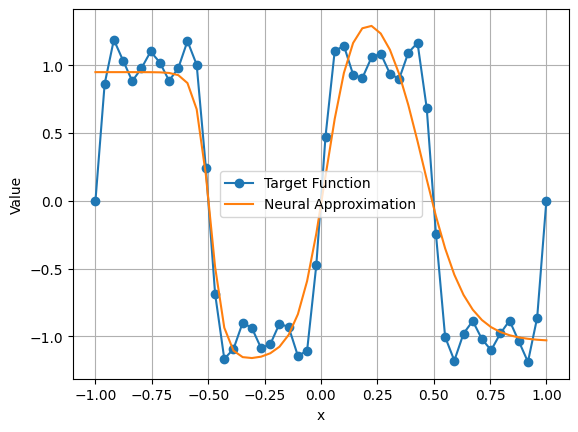

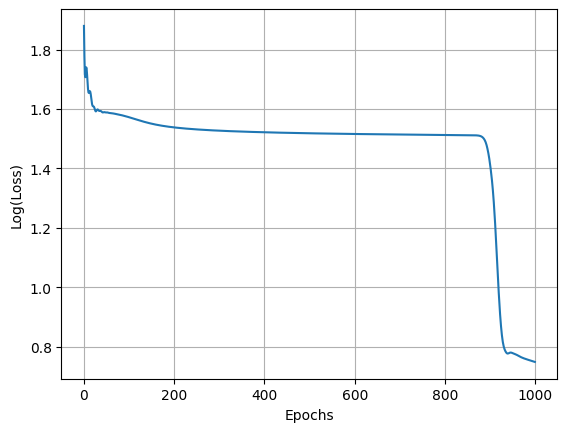

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
from tqdm import tqdm
# Function to approximate
def target_function(t):
    #return np.sin(4 * t) + np.cos(10 * t)
    f = np.zeros_like(t)  # Initialize the square wave
    N_terms = 3
    A = 1.0
    T = 1.0
    f = np.zeros_like(t)  # Initialize the square wave
    for n in range(1, 2 * N_terms, 2):  # Only odd terms
        f += (4 * A / np.pi) * np.sin(2 * np.pi * n * t / T) / n
    return f

# Generate data
x_values = np.linspace(-1, 1, 50)
y_values = target_function(x_values)

# Convert to PyTorch tensors
x_tensor = torch.from_numpy(np.atleast_2d(x_values).T).float()
y_tensor = torch.from_numpy(y_values).float()

# Network configuration
input_size = 1
output_size = 1
hidden_neurons = 3  # Adjust this to see how the approximation improves


# Initialize hidden layer weights and biases (Xavier)
w = torch.randn((hidden_neurons, input_size)) * np.sqrt(2. / (input_size + hidden_neurons))
b = torch.randn(hidden_neurons)  # Biases can be initialized to zero

# Initialize output layer weights and biases (Xavier)
v = torch.randn(hidden_neurons) * np.sqrt(2. / (hidden_neurons + output_size))
v0 = torch.randn(1)  # Single bias for the output layer

# Enable gradient tracking
w.requires_grad_(True)
b.requires_grad_(True)
v.requires_grad_(True)
v0.requires_grad_(True)


# Representation: Neural network approximation function
def neural_approximator(x):
    z = torch.sigmoid(x @ w.T + b)
    output = z @ v + v0
    return output
# Training configuration
learning_rate = 1e-1
epochs = 1000
optimizer = optim.Adam([w, b,v,v0], lr=learning_rate)
loss_history = []

# Training loop
for epoch in tqdm(range(epochs)):
    #Representation
    approximation = neural_approximator(x_tensor)
    # Evaluation
    loss = torch.sum((approximation - y_tensor) ** 2)
    # Optimization
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    loss_history.append(loss.item())
# Plot the target function and its neural approximation
plt.figure()
plt.plot(x_values, y_values, 'o-', label='Target Function')
plt.plot(x_values, neural_approximator(x_tensor).detach().numpy(), label='Neural Approximation')
plt.xlabel('x')
plt.ylabel('Value')
plt.grid()
plt.legend()
plt.show()

# Plot loss history
plt.figure()
plt.plot(np.log10(loss_history))
plt.xlabel('Epochs')
plt.ylabel('Log(Loss)')
plt.grid()
plt.show()


Let's see how the function can be represented as a summation of sigmoids. Isn't it strange that a function like the one given above can be represented in terms of such sigmoids?

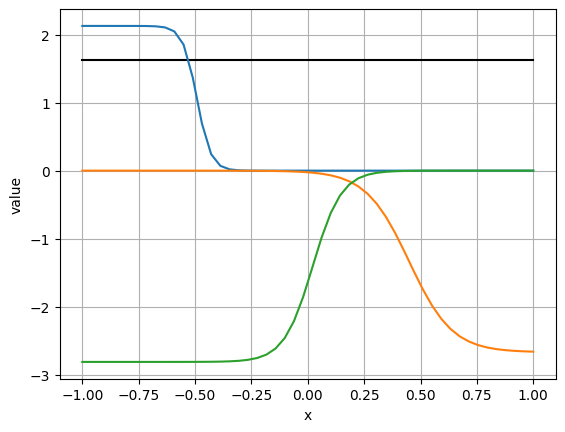

In [2]:
plt.figure();
x = x_tensor
plt.plot(x,[float(v0[0].detach().numpy())]*len(x),'k')
plt.plot(x,(v*torch.sigmoid(x@w.T+b)).detach().numpy())
plt.xlabel('x');plt.ylabel('value');plt.grid();


Below is a more pytorch style neural network looking implementation of the same thing:

100%|██████████| 1000/1000 [00:02<00:00, 469.68it/s]


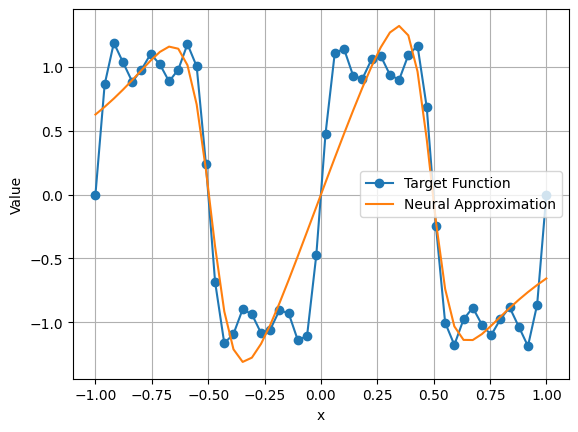

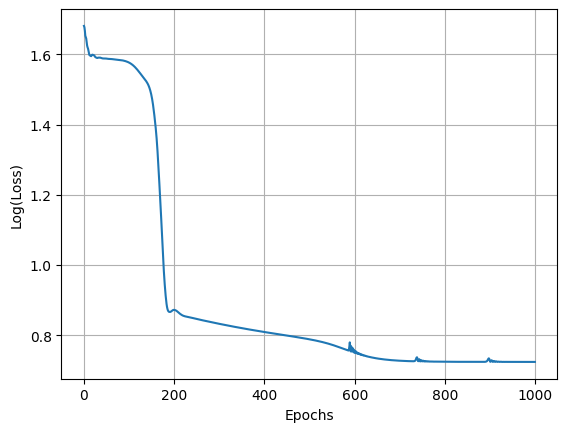

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm

# Define the neural network architecture as a class
model = nn.Sequential(
            nn.Linear(input_size, hidden_neurons),  # Input layer to hidden layer
            nn.Sigmoid(),                           # Non-linearity
            nn.Linear(hidden_neurons, output_size), # Output layer
        )
# Training configuration
learning_rate = 1e-1
epochs = 1000
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_history = []

# Training loop
for epoch in tqdm(range(epochs)):
    # Zero the gradients
    optimizer.zero_grad()
    # Forward pass
    approximation = model(x_tensor)
    # Compute loss
    loss = torch.sum((approximation.squeeze() - y_tensor) ** 2)  # Ensure approximation is squeezed to match y_tensor's shape
    # Backward pass
    loss.backward()
    # Update weights
    optimizer.step()
    # Record loss history
    loss_history.append(loss.item())
plt.figure()
plt.plot(x_values, y_values, 'o-', label='Target Function')
plt.plot(x_values, model(x_tensor).detach().numpy(), label='Neural Approximation')
plt.xlabel('x')
plt.ylabel('Value')
plt.grid()
plt.legend()
plt.show()
# Plot loss history
plt.figure()
plt.plot(np.log10(loss_history))
plt.xlabel('Epochs')
plt.ylabel('Log(Loss)')
plt.grid()
plt.show()

## Experiments to be done by students:
1. What is the impact of the number of neurons P?
2. Can you approximate any function?
3. What happens if we add another layer?

## More layers improve representation?

Let's see if a deeper model is more efficient at representing a complex function in comparison to a shallower one. Here we use a simple code to test this such that a deeper model and a shallow model have roughly the same number of parameters but the deeper model is (usually!) better for this problem. However, note that this may not always be the case depending upon a number of factors (application type, examples, training strategy, optimization method, architecture) etc.

100%|██████████| 5000/5000 [00:05<00:00, 857.02it/s]


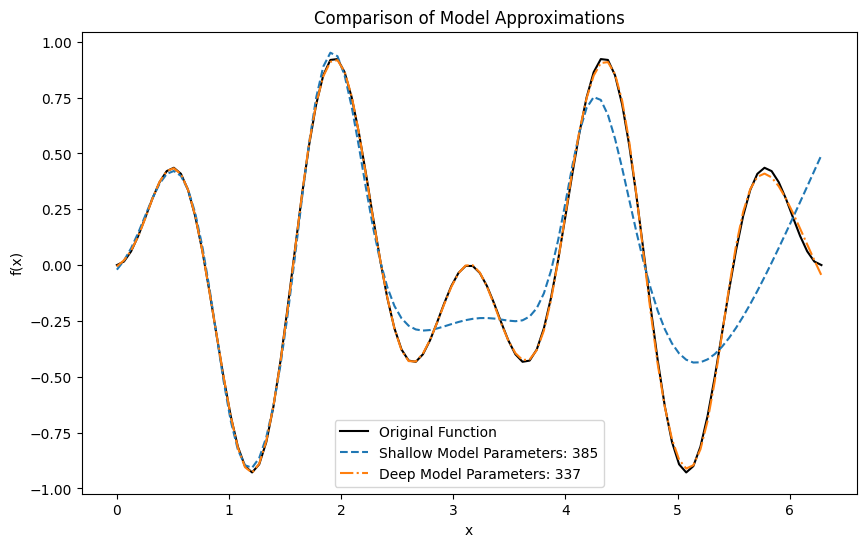

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
import torch.nn as nn

# Generate synthetic data
x = np.linspace(0, 2 * np.pi, 100)
y = np.sin(x) * np.sin(4 * x)
# Convert to PyTorch tensors
x_tensor = torch.tensor(x, dtype=torch.float32).view(-1, 1)
y_tensor = torch.tensor(y, dtype=torch.float32).view(-1, 1)

def create_shallow_model(input_size, output_size):
    # A shallow model with more neurons in a single hidden layer
    return nn.Sequential(
        nn.Linear(input_size, 128),
        nn.Sigmoid(),
        nn.Linear(128, output_size)
    )

def create_deep_model(input_size, output_size):
    # A deeper model with multiple hidden layers but fewer neurons
    return nn.Sequential(
        nn.Linear(input_size, 32),
        nn.Sigmoid(),
        nn.Linear(32, 8),
        nn.Sigmoid(),
        nn.Linear(8, output_size)
    )
def train_model(model, x_tensor, y_tensor, epochs=5000, learning_rate=1e-2):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()
    for epoch in tqdm(range(epochs)):
        optimizer.zero_grad()
        output = model(x_tensor)
        loss = criterion(output, y_tensor)
        loss.backward()
        optimizer.step()
    return model
# Create and train the shallow model
shallow_model = create_shallow_model(1, 1)
trained_shallow_model = train_model(shallow_model, x_tensor, y_tensor)

# Create and train the deep model
deep_model = create_deep_model(1, 1)
trained_deep_model = train_model(deep_model, x_tensor, y_tensor)

# Generate predictions
with torch.no_grad():
    shallow_predictions = trained_shallow_model(x_tensor)
    deep_predictions = trained_deep_model(x_tensor)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

shallow_count,deep_count = count_parameters(shallow_model),count_parameters(deep_model)
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x, y, label='Original Function', color='black')
plt.plot(x, shallow_predictions.numpy(), label=f'Shallow Model Parameters: {shallow_count}', linestyle='--')
plt.plot(x, deep_predictions.numpy(), label=f'Deep Model Parameters: {deep_count}', linestyle='-.')
plt.legend()
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('Comparison of Model Approximations')
plt.show()

